# Deep Neural Networks for Regression problems

Neural networks are well known for classification problems, for example, they are used in handwritten digits classification, but the question is will it be fruitful if we used them for regression problems?

In this article I will use a deep neural network to predict house pricing using a dataset from Kaggle .

You can download the dataset from [Here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


![](https://cdn-images-1.medium.com/max/2000/1*vUKwarc7rCouMzSt0Ksakw.jpeg)

## Contents :
    1- Process the dataset
    2- Make the deep neural network
    3- Train the DNN
    4- Test the DNN
    5- Compare the result from the DNN to another ML algorithm

**First of all, we will import the needed dependencies :**

In [4]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

## First : Processing the dataset 
We will not go deep in processing the dataset, all we want to do is getting the dataset ready to be fed into our models .

We will get rid of any features with missing values, then we will encode the categorical features, that's it.


### Load the dataset :
* Load train and test data into pandas DataFrames
* Combine train and test data to process them together

In [5]:
def get_data():
    #get train data
    train_data_path ='train-EG.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='test-EG.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.SalePrice
  train.drop(['SalePrice'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['index', 'Id'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [6]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


let's define a function to get the columns that don't have any missing values 

In [7]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

Get the columns that do not have any missing values .

In [8]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

Let's see how many columns we got

In [9]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


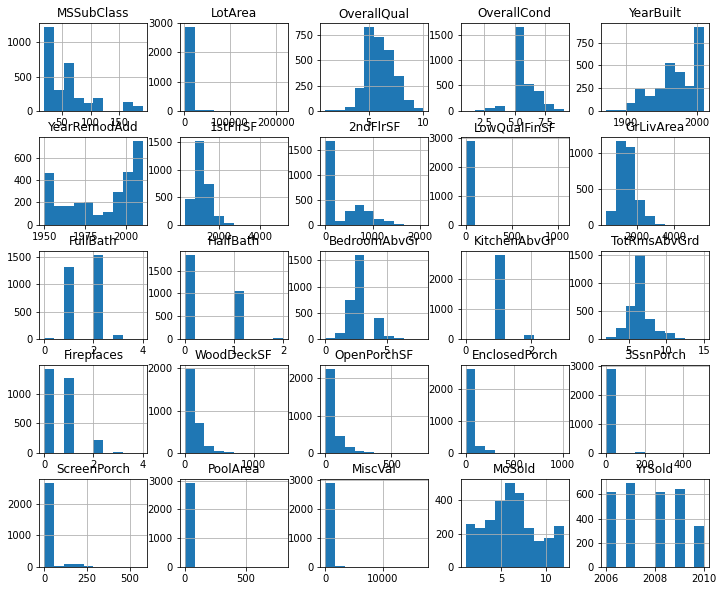

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

**The correlation between the features**

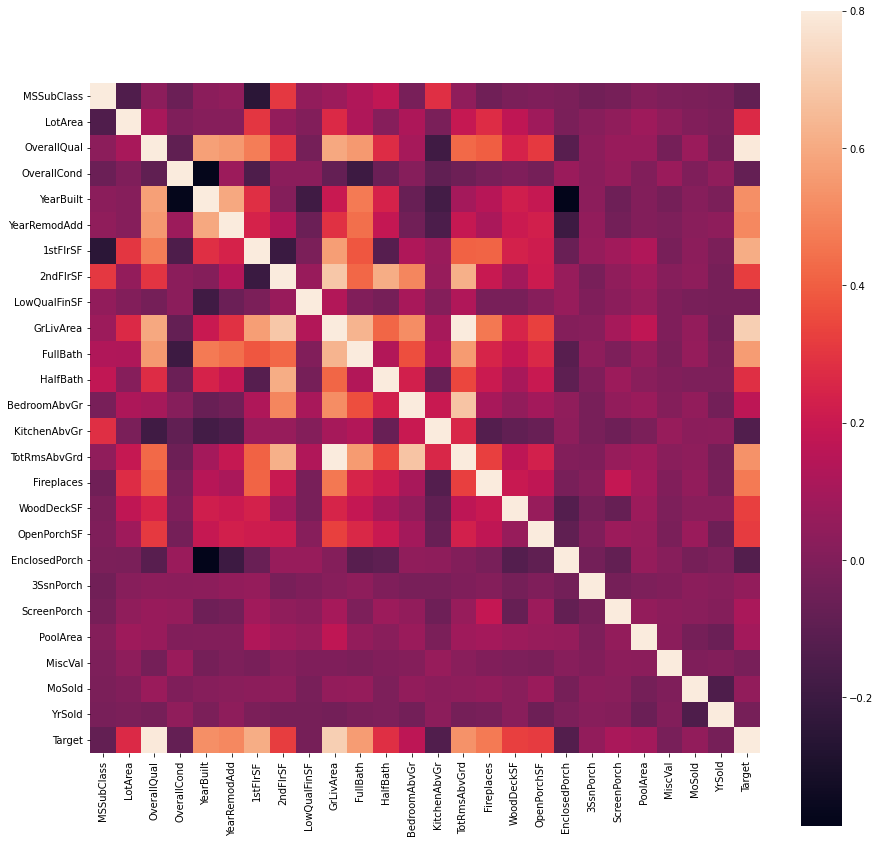

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

From the correlation heatmap above, we see that about 15 features are highly correlated with the target.

**One Hot Encode The Categorical Features :**

We will encode the categorical features using one hot encoding.

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

In [13]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


Now, split back combined dataFrame to training data and test data 

In [14]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 

In [15]:
train, test = split_combined()

## Second : Make the Deep Neural Network
 * Define a sequential model
 * Add some dense layers
 * Use '**relu**' as the activation function in the hidden layers
 * Use a '**normal**' initializer as the kernal_intializer 
           Initializers define the way to set the initial random weights of Keras layers.
 * We will use mean_absolute_error as a loss function
 * Define the output layer with only one node
 * Use 'linear 'as the activation function for the output layer
 


In [16]:
NN_model = Sequential()

**The Input Layer**

In [17]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

**The Hidden Layers**

In [18]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

**The Output Layer**

In [19]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

**Compile the network**

In [20]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               19200     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


**Define a checkpoint callback :**

In [21]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Third : Train the model :

In [22]:
NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
37/37 [==============================] - 1s 6ms/step - loss: 128279.0859 - mean_absolute_error: 128279.0859 - val_loss: 56959.8594 - val_mean_absolute_error: 56959.8594

Epoch 00001: val_loss improved from inf to 56959.85938, saving model to Weights-001--56959.85938.hdf5
Epoch 2/500
37/37 [==============================] - 0s 2ms/step - loss: 55421.5625 - mean_absolute_error: 55421.5625 - val_loss: 47534.3828 - val_mean_absolute_error: 47534.3828

Epoch 00002: val_loss improved from 56959.85938 to 47534.38281, saving model to Weights-002--47534.38281.hdf5
Epoch 3/500
37/37 [==============================] - 0s 2ms/step - loss: 46805.4648 - mean_absolute_error: 46805.4648 - val_loss: 43994.3203 - val_mean_absolute_error: 43994.3203

Epoch 00003: val_loss improved from 47534.38281 to 43994.32031, saving model to Weights-003--43994.32031.hdf5
Epoch 4/500
37/37 [==============================] - 0s 2ms/step - loss: 41046.4023 - mean_absolute_error: 41046.4023 - val_loss: 41525.

37/37 [==============================] - 0s 3ms/step - loss: 32539.2012 - mean_absolute_error: 32539.2012 - val_loss: 34068.3359 - val_mean_absolute_error: 34068.3359

Epoch 00033: val_loss did not improve from 34046.69922
Epoch 34/500
37/37 [==============================] - 0s 2ms/step - loss: 30198.2051 - mean_absolute_error: 30198.2051 - val_loss: 34430.4570 - val_mean_absolute_error: 34430.4570

Epoch 00034: val_loss did not improve from 34046.69922
Epoch 35/500
37/37 [==============================] - 0s 3ms/step - loss: 30336.0039 - mean_absolute_error: 30336.0039 - val_loss: 34296.1328 - val_mean_absolute_error: 34296.1328

Epoch 00035: val_loss did not improve from 34046.69922
Epoch 36/500
37/37 [==============================] - 0s 3ms/step - loss: 30443.3906 - mean_absolute_error: 30443.3906 - val_loss: 34225.3906 - val_mean_absolute_error: 34225.3906

Epoch 00036: val_loss did not improve from 34046.69922
Epoch 37/500
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 3ms/step - loss: 28091.3770 - mean_absolute_error: 28091.3770 - val_loss: 31426.0762 - val_mean_absolute_error: 31426.0762

Epoch 00066: val_loss did not improve from 31423.05078
Epoch 67/500
37/37 [==============================] - 0s 3ms/step - loss: 27695.3086 - mean_absolute_error: 27695.3086 - val_loss: 37851.1328 - val_mean_absolute_error: 37851.1328

Epoch 00067: val_loss did not improve from 31423.05078
Epoch 68/500
37/37 [==============================] - 0s 3ms/step - loss: 28365.2480 - mean_absolute_error: 28365.2480 - val_loss: 30827.7266 - val_mean_absolute_error: 30827.7266

Epoch 00068: val_loss improved from 31423.05078 to 30827.72656, saving model to Weights-068--30827.72656.hdf5
Epoch 69/500
37/37 [==============================] - 0s 3ms/step - loss: 27484.4746 - mean_absolute_error: 27484.4746 - val_loss: 32625.9688 - val_mean_absolute_error: 32625.9688

Epoch 00069: val_loss did not improve from 30827.72656
Epoch 70/500
3

37/37 [==============================] - 0s 3ms/step - loss: 24635.5410 - mean_absolute_error: 24635.5410 - val_loss: 26683.7539 - val_mean_absolute_error: 26683.7539

Epoch 00099: val_loss did not improve from 26118.06641
Epoch 100/500
37/37 [==============================] - 0s 3ms/step - loss: 22931.6035 - mean_absolute_error: 22931.6035 - val_loss: 25502.5332 - val_mean_absolute_error: 25502.5332

Epoch 00100: val_loss improved from 26118.06641 to 25502.53320, saving model to Weights-100--25502.53320.hdf5
Epoch 101/500
37/37 [==============================] - 0s 3ms/step - loss: 22465.7559 - mean_absolute_error: 22465.7559 - val_loss: 25140.1152 - val_mean_absolute_error: 25140.1152

Epoch 00101: val_loss improved from 25502.53320 to 25140.11523, saving model to Weights-101--25140.11523.hdf5
Epoch 102/500
37/37 [==============================] - 0s 3ms/step - loss: 22651.0137 - mean_absolute_error: 22651.0137 - val_loss: 25699.4551 - val_mean_absolute_error: 25699.4551

Epoch 00102

37/37 [==============================] - 0s 3ms/step - loss: 21470.9023 - mean_absolute_error: 21470.9023 - val_loss: 22997.6152 - val_mean_absolute_error: 22997.6152

Epoch 00132: val_loss did not improve from 22385.88086
Epoch 133/500
37/37 [==============================] - 0s 3ms/step - loss: 19896.0098 - mean_absolute_error: 19896.0098 - val_loss: 23467.0957 - val_mean_absolute_error: 23467.0957

Epoch 00133: val_loss did not improve from 22385.88086
Epoch 134/500
37/37 [==============================] - 0s 3ms/step - loss: 19762.6621 - mean_absolute_error: 19762.6621 - val_loss: 22928.4785 - val_mean_absolute_error: 22928.4785

Epoch 00134: val_loss did not improve from 22385.88086
Epoch 135/500
37/37 [==============================] - 0s 3ms/step - loss: 19561.1934 - mean_absolute_error: 19561.1934 - val_loss: 27695.1992 - val_mean_absolute_error: 27695.1992

Epoch 00135: val_loss did not improve from 22385.88086
Epoch 136/500
37/37 [==============================] - 0s 3ms/step


Epoch 00165: val_loss did not improve from 21353.44336
Epoch 166/500
37/37 [==============================] - 0s 3ms/step - loss: 18085.0684 - mean_absolute_error: 18085.0684 - val_loss: 22407.1426 - val_mean_absolute_error: 22407.1426

Epoch 00166: val_loss did not improve from 21353.44336
Epoch 167/500
37/37 [==============================] - 0s 3ms/step - loss: 18137.8828 - mean_absolute_error: 18137.8828 - val_loss: 22411.2500 - val_mean_absolute_error: 22411.2500

Epoch 00167: val_loss did not improve from 21353.44336
Epoch 168/500
37/37 [==============================] - 0s 3ms/step - loss: 17786.9883 - mean_absolute_error: 17786.9883 - val_loss: 22677.2246 - val_mean_absolute_error: 22677.2246

Epoch 00168: val_loss did not improve from 21353.44336
Epoch 169/500
37/37 [==============================] - 0s 3ms/step - loss: 19996.0879 - mean_absolute_error: 19996.0879 - val_loss: 33806.5430 - val_mean_absolute_error: 33806.5430

Epoch 00169: val_loss did not improve from 21353.44

37/37 [==============================] - 0s 3ms/step - loss: 17022.3535 - mean_absolute_error: 17022.3535 - val_loss: 25740.1816 - val_mean_absolute_error: 25740.1816

Epoch 00200: val_loss did not improve from 20981.09961
Epoch 201/500
37/37 [==============================] - 0s 3ms/step - loss: 18716.3145 - mean_absolute_error: 18716.3145 - val_loss: 23723.3047 - val_mean_absolute_error: 23723.3047

Epoch 00201: val_loss did not improve from 20981.09961
Epoch 202/500
37/37 [==============================] - 0s 3ms/step - loss: 18050.4102 - mean_absolute_error: 18050.4102 - val_loss: 22397.4453 - val_mean_absolute_error: 22397.4453

Epoch 00202: val_loss did not improve from 20981.09961
Epoch 203/500
37/37 [==============================] - 0s 3ms/step - loss: 17639.7988 - mean_absolute_error: 17639.7988 - val_loss: 21404.1035 - val_mean_absolute_error: 21404.1035

Epoch 00203: val_loss did not improve from 20981.09961
Epoch 204/500
37/37 [==============================] - 0s 3ms/step

37/37 [==============================] - 0s 3ms/step - loss: 17259.0703 - mean_absolute_error: 17259.0703 - val_loss: 21124.6602 - val_mean_absolute_error: 21124.6602

Epoch 00234: val_loss did not improve from 20855.70117
Epoch 235/500
37/37 [==============================] - 0s 3ms/step - loss: 17000.1797 - mean_absolute_error: 17000.1797 - val_loss: 20973.0449 - val_mean_absolute_error: 20973.0449

Epoch 00235: val_loss did not improve from 20855.70117
Epoch 236/500
37/37 [==============================] - 0s 3ms/step - loss: 17211.0020 - mean_absolute_error: 17211.0020 - val_loss: 21854.5781 - val_mean_absolute_error: 21854.5781

Epoch 00236: val_loss did not improve from 20855.70117
Epoch 237/500
37/37 [==============================] - 0s 3ms/step - loss: 16666.7715 - mean_absolute_error: 16666.7715 - val_loss: 21528.7520 - val_mean_absolute_error: 21528.7520

Epoch 00237: val_loss did not improve from 20855.70117
Epoch 238/500
37/37 [==============================] - 0s 3ms/step


Epoch 00267: val_loss did not improve from 20380.97266
Epoch 268/500
37/37 [==============================] - 0s 3ms/step - loss: 18370.0312 - mean_absolute_error: 18370.0312 - val_loss: 21432.2793 - val_mean_absolute_error: 21432.2793

Epoch 00268: val_loss did not improve from 20380.97266
Epoch 269/500
37/37 [==============================] - 0s 3ms/step - loss: 16271.1660 - mean_absolute_error: 16271.1660 - val_loss: 22798.3223 - val_mean_absolute_error: 22798.3223

Epoch 00269: val_loss did not improve from 20380.97266
Epoch 270/500
37/37 [==============================] - 0s 3ms/step - loss: 18185.7051 - mean_absolute_error: 18185.7051 - val_loss: 25981.0859 - val_mean_absolute_error: 25981.0859

Epoch 00270: val_loss did not improve from 20380.97266
Epoch 271/500
37/37 [==============================] - 0s 3ms/step - loss: 17025.1621 - mean_absolute_error: 17025.1621 - val_loss: 21959.7812 - val_mean_absolute_error: 21959.7812

Epoch 00271: val_loss did not improve from 20380.97

37/37 [==============================] - 0s 3ms/step - loss: 15478.3867 - mean_absolute_error: 15478.3867 - val_loss: 21414.4688 - val_mean_absolute_error: 21414.4688

Epoch 00302: val_loss did not improve from 19910.94141
Epoch 303/500
37/37 [==============================] - 0s 2ms/step - loss: 15847.0137 - mean_absolute_error: 15847.0137 - val_loss: 20807.6484 - val_mean_absolute_error: 20807.6484

Epoch 00303: val_loss did not improve from 19910.94141
Epoch 304/500
37/37 [==============================] - 0s 2ms/step - loss: 16593.3789 - mean_absolute_error: 16593.3789 - val_loss: 19860.5625 - val_mean_absolute_error: 19860.5625

Epoch 00304: val_loss improved from 19910.94141 to 19860.56250, saving model to Weights-304--19860.56250.hdf5
Epoch 305/500
37/37 [==============================] - 0s 2ms/step - loss: 15115.0684 - mean_absolute_error: 15115.0684 - val_loss: 19945.1055 - val_mean_absolute_error: 19945.1055

Epoch 00305: val_loss did not improve from 19860.56250
Epoch 306/5

37/37 [==============================] - 0s 3ms/step - loss: 15325.8662 - mean_absolute_error: 15325.8662 - val_loss: 25888.4688 - val_mean_absolute_error: 25888.4688

Epoch 00336: val_loss did not improve from 19860.56250
Epoch 337/500
37/37 [==============================] - 0s 2ms/step - loss: 15767.7607 - mean_absolute_error: 15767.7607 - val_loss: 21505.6504 - val_mean_absolute_error: 21505.6504

Epoch 00337: val_loss did not improve from 19860.56250
Epoch 338/500
37/37 [==============================] - 0s 3ms/step - loss: 15028.9541 - mean_absolute_error: 15028.9541 - val_loss: 21244.6836 - val_mean_absolute_error: 21244.6836

Epoch 00338: val_loss did not improve from 19860.56250
Epoch 339/500
37/37 [==============================] - 0s 3ms/step - loss: 16093.8184 - mean_absolute_error: 16093.8184 - val_loss: 21340.5664 - val_mean_absolute_error: 21340.5664

Epoch 00339: val_loss did not improve from 19860.56250
Epoch 340/500
37/37 [==============================] - 0s 3ms/step

37/37 [==============================] - 0s 2ms/step - loss: 16961.2266 - mean_absolute_error: 16961.2266 - val_loss: 20051.0664 - val_mean_absolute_error: 20051.0664

Epoch 00370: val_loss did not improve from 19732.57812
Epoch 371/500
37/37 [==============================] - 0s 2ms/step - loss: 15285.2520 - mean_absolute_error: 15285.2520 - val_loss: 19905.2129 - val_mean_absolute_error: 19905.2129

Epoch 00371: val_loss did not improve from 19732.57812
Epoch 372/500
37/37 [==============================] - 0s 3ms/step - loss: 14399.7275 - mean_absolute_error: 14399.7275 - val_loss: 21380.6211 - val_mean_absolute_error: 21380.6211

Epoch 00372: val_loss did not improve from 19732.57812
Epoch 373/500
37/37 [==============================] - 0s 3ms/step - loss: 16023.2393 - mean_absolute_error: 16023.2393 - val_loss: 19981.3574 - val_mean_absolute_error: 19981.3574

Epoch 00373: val_loss did not improve from 19732.57812
Epoch 374/500
37/37 [==============================] - 0s 3ms/step


Epoch 00404: val_loss did not improve from 19732.57812
Epoch 405/500
37/37 [==============================] - 0s 3ms/step - loss: 14091.6104 - mean_absolute_error: 14091.6104 - val_loss: 19437.6289 - val_mean_absolute_error: 19437.6289

Epoch 00405: val_loss improved from 19732.57812 to 19437.62891, saving model to Weights-405--19437.62891.hdf5
Epoch 406/500
37/37 [==============================] - 0s 2ms/step - loss: 15078.7227 - mean_absolute_error: 15078.7227 - val_loss: 21673.4258 - val_mean_absolute_error: 21673.4258

Epoch 00406: val_loss did not improve from 19437.62891
Epoch 407/500
37/37 [==============================] - 0s 2ms/step - loss: 15357.2432 - mean_absolute_error: 15357.2432 - val_loss: 20464.7656 - val_mean_absolute_error: 20464.7656

Epoch 00407: val_loss did not improve from 19437.62891
Epoch 408/500
37/37 [==============================] - 0s 3ms/step - loss: 14533.4248 - mean_absolute_error: 14533.4248 - val_loss: 19543.1758 - val_mean_absolute_error: 19543.17

37/37 [==============================] - 0s 2ms/step - loss: 14823.4346 - mean_absolute_error: 14823.4346 - val_loss: 21554.6484 - val_mean_absolute_error: 21554.6484

Epoch 00439: val_loss did not improve from 19270.42773
Epoch 440/500
37/37 [==============================] - 0s 3ms/step - loss: 14937.9004 - mean_absolute_error: 14937.9004 - val_loss: 22295.6230 - val_mean_absolute_error: 22295.6230

Epoch 00440: val_loss did not improve from 19270.42773
Epoch 441/500
37/37 [==============================] - 0s 3ms/step - loss: 14431.2500 - mean_absolute_error: 14431.2500 - val_loss: 19961.2754 - val_mean_absolute_error: 19961.2754

Epoch 00441: val_loss did not improve from 19270.42773
Epoch 442/500
37/37 [==============================] - 0s 3ms/step - loss: 15434.2910 - mean_absolute_error: 15434.2910 - val_loss: 20099.0625 - val_mean_absolute_error: 20099.0625

Epoch 00442: val_loss did not improve from 19270.42773
Epoch 443/500
37/37 [==============================] - 0s 3ms/step

37/37 [==============================] - 0s 3ms/step - loss: 13862.7598 - mean_absolute_error: 13862.7598 - val_loss: 20517.2441 - val_mean_absolute_error: 20517.2441

Epoch 00473: val_loss did not improve from 19149.90234
Epoch 474/500
37/37 [==============================] - 0s 3ms/step - loss: 14319.6309 - mean_absolute_error: 14319.6309 - val_loss: 19987.2773 - val_mean_absolute_error: 19987.2773

Epoch 00474: val_loss did not improve from 19149.90234
Epoch 475/500
37/37 [==============================] - 0s 3ms/step - loss: 13429.1924 - mean_absolute_error: 13429.1924 - val_loss: 24111.7344 - val_mean_absolute_error: 24111.7344

Epoch 00475: val_loss did not improve from 19149.90234
Epoch 476/500
37/37 [==============================] - 0s 3ms/step - loss: 16236.9404 - mean_absolute_error: 16236.9404 - val_loss: 20523.9238 - val_mean_absolute_error: 20523.9238

Epoch 00476: val_loss did not improve from 19149.90234
Epoch 477/500
37/37 [==============================] - 0s 3ms/step

In [24]:
# Load wights file of the best model :
wights_file = 'Weights-459--19149.90234.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

We see that the validation loss of the best model is 18738.19 

## Fourth : Test the model
We will submit the predictions on the test data to Kaggle and see how good our model is.

In [28]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('test-EG.csv').Id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

In [29]:
predictions = NN_model.predict(test)

In [30]:
make_submission(predictions[:,0],'submission(NN).csv')

A submission file has been made


![](https://cdn-images-1.medium.com/max/800/1*mXbUrGB9yB9RrBscwugP9g.png)

Not bad at all, with some more preprocessing, and more training, we can do better.


## Fifth: Try another ML algorithms :
Now, let us try another ML algorithm to compare the results.

We will use random forest regressor and XGBRegressor.

**Split training data to training and validation data**

In [31]:
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.25, random_state = 14)


**We will try Random forest model first.**

In [32]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

RandomForestRegressor()

**Get the mean absolute error on the validation data **

In [33]:
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  17731.9500913242


**Make a submission file and submit it to Kaggle to see the result.**

In [34]:
predicted_prices = model.predict(test)
make_submission(predicted_prices,'Submission(RF).csv')

A submission file has been made


![](https://cdn-images-1.medium.com/max/800/1*wcJqKzBsbLARqMjwvv0Xjw.png)

**Now, let us try XGBoost model**

In [35]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

**Get the mean absolute error on the validation data**

In [36]:
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  19944.331282106163


**Make a submission file and submit it to Kaggle to see the result.**

In [37]:
XGBpredictions = XGBModel.predict(test)
make_submission(XGBpredictions,'Submission(XGB).csv')

A submission file has been made


![](https://cdn-images-1.medium.com/max/800/1*PO0jxykz1hv-aSN5kkjItg.png)

Isn't that a surprise, I really did not think that neural networks will beat random forests and XGBoost algorithms, but let us try not to be too optimistic, remember that we did not configure any hyperparameters on random forest and XGBoost models, I believe if we did so, these two models would outscore neural networks.